# **E533 DLS: Homework 4**
---

# Problem 1:





In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Input, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal, HeUniform
from tensorflow.keras.callbacks import CSVLogger

import matplotlib.pyplot as plt
import seaborn as sns
# !pip install librosa 
# import librosa
# import librosa.display

%matplotlib inline 

%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
x_train, x_test = x_train/255, x_test/255
CLASSES = 10
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

### 1.1 Fully connected DNN

In [ ]:
model_dnn = keras.Sequential([
                              Flatten(input_shape=(28,28), name='input_flatten'),
                              Dense(1024, kernel_initializer=HeUniform(), activation='relu', name='dense_layer_1'),
                              BatchNormalization(),
                              Dropout(0.2),
                              Dense(1024, kernel_initializer=HeUniform(), activation='relu', name='dense_layer_2'),
                              BatchNormalization(),
                              Dropout(0.2),
                              Dense(1024, kernel_initializer=HeUniform(), activation='relu', name='dense_layer_3'),
                              BatchNormalization(),
                              Dropout(0.2),
                              Dense(1024, kernel_initializer=HeUniform(), activation='relu', name='dense_layer_4'),
                              BatchNormalization(),
                              Dropout(0.2),
                              Dense(1024, kernel_initializer=HeUniform(), activation='relu', name='dense_layer_5'),
                              BatchNormalization(),
                              Dropout(0.2),

                              Dense(CLASSES, activation='softmax', name='output_layer')

])

model_dnn.compile(
    optimizer = Adam(learning_rate=1e-03),
    loss = CategoricalCrossentropy(),
    metrics = ['Accuracy']
)
model_dnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_flatten (Flatten)      (None, 784)               0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_21 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)             

In [ ]:
model_dnn_csv_log = CSVLogger("model_dnn_csv_log.csv")
model_dnn.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2,
    callbacks = [model_dnn_csv_log]
)

!cp model_dnn_csv_log.csv "drive/MyDrive/e533_hw4/Part1/"

Epoch 1/100
118/118 - 4s - loss: 0.2871 - Accuracy: 0.9168 - val_loss: 0.3258 - val_Accuracy: 0.8796
Epoch 2/100
118/118 - 2s - loss: 0.1006 - Accuracy: 0.9682 - val_loss: 0.1240 - val_Accuracy: 0.9582
Epoch 3/100
118/118 - 2s - loss: 0.0697 - Accuracy: 0.9776 - val_loss: 0.1013 - val_Accuracy: 0.9707
Epoch 4/100
118/118 - 2s - loss: 0.0591 - Accuracy: 0.9807 - val_loss: 0.0813 - val_Accuracy: 0.9774
Epoch 5/100
118/118 - 2s - loss: 0.0452 - Accuracy: 0.9854 - val_loss: 0.0809 - val_Accuracy: 0.9792
Epoch 6/100
118/118 - 2s - loss: 0.0372 - Accuracy: 0.9876 - val_loss: 0.0817 - val_Accuracy: 0.9793
Epoch 7/100
118/118 - 2s - loss: 0.0375 - Accuracy: 0.9878 - val_loss: 0.0695 - val_Accuracy: 0.9818
Epoch 8/100
118/118 - 2s - loss: 0.0273 - Accuracy: 0.9909 - val_loss: 0.0709 - val_Accuracy: 0.9809
Epoch 9/100
118/118 - 2s - loss: 0.0272 - Accuracy: 0.9910 - val_loss: 0.0806 - val_Accuracy: 0.9807
Epoch 10/100
118/118 - 2s - loss: 0.0304 - Accuracy: 0.9902 - val_loss: 0.0682 - val_Accura

In [ ]:
model_dnn.save('hw3_part1_model_dnn.h5')
!cp hw3_part1_model_dnn.h5  "drive/MyDrive/e533_hw4/Part1/"

### 1.2 Applying SVD on the weight matrices

In [ ]:
model_dnn_loaded = keras.models.load_model('drive/MyDrive/e533_hw4/Part1/hw3_part1_model_dnn.h5')
model_weights = [model_dnn_loaded.trainable_weights[i] for i in range(0, len(model_dnn_loaded.trainable_weights), 4 )]

print('Shapes of model layer weight matrices:\n ',[model_weights[i].shape for i in  range(5)])
print('---')
print('Shape of ouput layer matrix:\n', model_weights[5].shape)

Shapes of model layer weight matrices:
  [TensorShape([784, 1024]), TensorShape([1024, 1024]), TensorShape([1024, 1024]), TensorShape([1024, 1024]), TensorShape([1024, 1024])]
---
Shape of ouput layer matrix:
 (1024, 10)


In [ ]:
SVD_layers = {k:[] for k in ['U', 'S', 'V']}

for m in model_weights[:-1]:
  u, s, v = np.linalg.svd(m, full_matrices=True)
  SVD_layers['U'].append(u)
  SVD_layers['S'].append(s)
  SVD_layers['V'].append(v)


In [ ]:
# Compress all layer SVD matrices for each cut-off value in D
def compress_matrices(SVD_layers, cutoff):
  temp = {}
  temp['U'] = [m[:,:cutoff] for m in SVD_layers['U']]
  temp['S'] = [m[:cutoff] for m in SVD_layers['S']]
  temp['V'] = [m[:cutoff,:] for m in SVD_layers['V']]
  return temp

D = [10, 20, 50, 100, 200]
SVD_compressed = {'full': SVD_layers}
for d in D:
  SVD_compressed[str(d)] = compress_matrices(SVD_layers, cutoff=d)


## 1.4 Predict & evaluate using SVD-compressed weights:

In [ ]:
def custom_predict(model, layer_weights, layer_names,  x=[], y=[], enable_printing = True):
  j=0
  # print(len(layer_weights))
  for layer_name in layer_names:
    temp_bias = model.get_layer(layer_name).get_weights()[1]
    # print(layer_weights[j].shape)
    # print(temp_bias.shape)
    model.get_layer(layer_name).set_weights([layer_weights[j], temp_bias])

    # model.layers[i].set_weights(layer_weights[j], temp_bias)
    j += 1

  eval = model.evaluate(x=x_test, y=y_test, use_multiprocessing=True)
  
  if enable_printing:
    print(f'D={d}\nLoss: {eval[0]} \| Accuracy: {eval[1]}')

  return model, eval

def get_matrix_from_svd(svd_dict):
  matrices = []
  for i in range(len(svd_dict['S'])):
    # matrices.append(np.dot(svd_dict['U'][i], np.dot(np.diag(np.dot(svd_dict['S'][i]), np.dot(svd_dict['V'][i])))))
    s, u, v_adj = svd_dict['S'][i], svd_dict['U'][i], svd_dict['V'][i]
    matrices.append(np.dot(u, np.dot(np.diag(s), v_adj)))
  return matrices


In [ ]:
import copy
LAYER_NAMES = ['dense_layer_1', 'dense_layer_2', 'dense_layer_3', 'dense_layer_4', 'dense_layer_5']
for d in SVD_compressed.keys():
  
  if d=='full':
    continue
  print('\n'+'='*5+'\n')
  layer_weights=get_matrix_from_svd(SVD_compressed[d])
  custom_predict(copy.copy(model_dnn_loaded), layer_weights, layer_names=LAYER_NAMES,  x=x_test, y=y_test)

eval = model_dnn_loaded.evaluate(x=x_test, y=y_test)
print(f'D="full"\nLoss: {eval[0]} | Accuracy: {eval[1]}')


=====

INFO:tensorflow:Assets written to: ram://752ce357-fcd9-4c9d-a7a5-ba3ebf244932/assets
313/313 [==============================] - 4s 5ms/step - loss: 4.3577 - Accuracy: 0.4472
D=10
Loss: 4.357693672180176 \| Accuracy: 0.4472000002861023

=====

INFO:tensorflow:Assets written to: ram://b64c599b-35d6-41e5-9e20-7117cbe4fa98/assets
313/313 [==============================] - 2s 5ms/step - loss: 0.7307 - Accuracy: 0.8674
D=20
Loss: 0.7307060360908508 \| Accuracy: 0.8673999905586243

=====

INFO:tensorflow:Assets written to: ram://7f41001d-1e27-4868-ad4e-4dd7523aa178/assets
313/313 [==============================] - 2s 5ms/step - loss: 0.0944 - Accuracy: 0.9797
D=50
Loss: 0.0943710207939148 \| Accuracy: 0.9797000288963318

=====

INFO:tensorflow:Assets written to: ram://5a7967e6-3d93-4d52-a4e7-65cb84e9f4cd/assets
313/313 [==============================] - 2s 5ms/step - loss: 0.0831 - Accuracy: 0.9848
D=100
Loss: 0.08309688419103622 \| Accuracy: 0.9847999811172485

=====

INFO:tensorflow

---
# Problem 2:


### 2.1 Creating a model with W = U * V (init U = U_20, V = S_20 * V_20)

In [ ]:
model_fine_20 = keras.Sequential([
                                Flatten(input_shape=(28,28), name='input_flatten'),
                                Dense(20, name='layer1_U'),
                                Dense(1024, name='layer1_V'),
                                keras.layers.Activation('relu'),

                                Dense(20, name='layer2_U'),
                                Dense(1024, name='layer2_V'),
                                keras.layers.Activation('relu'),

                                Dense(20, name='layer3_U'),
                                Dense(1024, name='layer3_V'),
                                keras.layers.Activation('relu'),                                
                                
                                Dense(20, name='layer4_U'),
                                Dense(1024, name='layer4_V'),
                                keras.layers.Activation('relu'),                                
                                
                                Dense(20, name='layer5_U'),
                                Dense(1024, name='layer5_V'),
                                keras.layers.Activation('relu'),                             
                                
                                Dense(10, activation='softmax', name='output_softmax')
                                ])

model_fine_20.compile(
    optimizer = Adam(learning_rate=1e-05),
    loss = CategoricalCrossentropy(),
    metrics = ['Accuracy']
)

model_fine_20.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_flatten (Flatten)     (None, 784)               0         
                                                                 
 layer1_U (Dense)            (None, 20)                15700     
                                                                 
 layer1_V (Dense)            (None, 1024)              21504     
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 layer2_U (Dense)            (None, 20)                20500     
                                                                 
 layer2_V (Dense)            (None, 1024)              21504     
                                                                 
 activation_1 (Activation)   (None, 1024)              0

### 2.2 Finetuning the model by using the weights from D=20 and 

In [ ]:
LAYER_NAMES_20 = ['layer1_U','layer1_V','layer2_U','layer2_V','layer3_U','layer3_V','layer4_U','layer4_V','layer5_U','layer5_V']
for layer_name, l in zip(LAYER_NAMES_20, sorted(list(range(5))*2)):
  temp_bias =  model_fine_20.get_layer(layer_name).get_weights()[1]
  s20, u20, v_adj20 = SVD_compressed['20']['S'][l], SVD_compressed['20']['U'][l], SVD_compressed['20']['V'][l]

  if 'U' in layer_name:
    model_fine_20.get_layer(layer_name).set_weights([u20, temp_bias])
  elif 'V' in layer_name:
    model_fine_20.get_layer(layer_name).set_weights([np.dot(np.diag(s20), v_adj20), temp_bias])

In [ ]:
model_fine_20_csv_log = CSVLogger("model_fine_20_csv_log.csv")

model_fine_20_fit = model_fine_20.fit(
    x=x_train,
    y=y_train,

    validation_data = (x_test, y_test),
    batch_size=512,
    epochs=100,
    callbacks=[model_fine_20_csv_log]
)


Epoch 1/100
118/118 [==============================] - 2s 13ms/step - loss: 1730.2849 - Accuracy: 0.1231 - val_loss: 855.0817 - val_Accuracy: 0.1755
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 462.2189 - Accuracy: 0.2989 - val_loss: 199.4389 - val_Accuracy: 0.4630
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 129.2103 - Accuracy: 0.5843 - val_loss: 83.0693 - val_Accuracy: 0.6782
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 65.5701 - Accuracy: 0.7276 - val_loss: 51.4618 - val_Accuracy: 0.7738
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 44.7016 - Accuracy: 0.7979 - val_loss: 38.8683 - val_Accuracy: 0.8212
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 34.8168 - Accuracy: 0.8340 - val_loss: 31.8375 - val_Accuracy: 0.8484
Epoch 7/100
118/118 [==============================] - 1s 11ms/step - loss: 28.6500 - Accuracy: 0.8574 - val_loss: 27.

In [ ]:
!cp model_fine_20_csv_log.csv "drive/MyDrive/e533_hw4/Part2/"

In [ ]:
print('Model Evaluation:')
model_fine_20.evaluate(x=x_test, y=y_test, batch_size=40)

Model Evaluation:
250/250 [==============================] - 1s 4ms/step - loss: 0.9175 - Accuracy: 0.9645


[0.9175010919570923, 0.9645000100135803]

* Validation Accuracy: 96.5



In [ ]:
model_fine_20_log = pd.read_csv('drive/MyDrive/e533_hw4/Part2/model_fine_20_csv_log.csv')

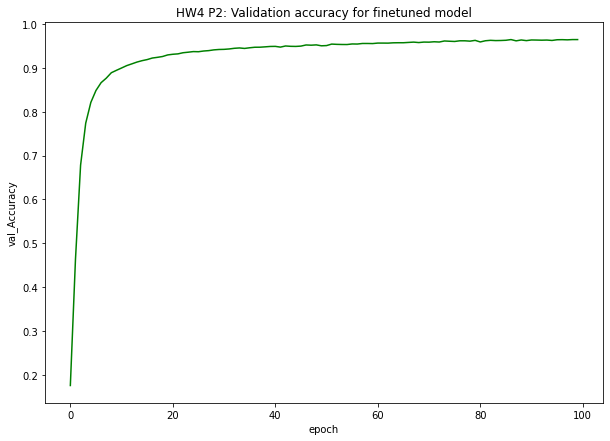

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.lineplot(x='epoch', y='val_Accuracy', color='green', data=model_fine_20_log, ax=ax)
# sns.lineplot(x='epoch', y='Accuracy', color='blue', data=model_fine_20_log, ax=ax)
# plt.legend()
ax.set_title('HW4 P2: Validation accuracy for finetuned model')
plt.show()

---
# Problem 3

In [5]:
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)

In [6]:
model_dnn_loaded = keras.models.load_model('drive/MyDrive/e533_hw4/Part1/hw3_part1_model_dnn.h5')
# model_dnn_loaded.summary()

In [7]:
def svd20(W, cutoff=20):
  """
  W: weight matrix
  """
  # print(type(W))
  s, u, v = tf.linalg.svd(W, full_matrices=True)
  u, s, v = u[:,:cutoff], s[:cutoff], v[:,:cutoff]
  # print(u.shape, s.shape, v.shape)
  return tf.matmul(u, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))
  # return np.dot(u, np.dot(np.diag(s), v))

In [8]:
class CustomLayer(Layer):
  def __init__(self, units, layer_num):
    super(CustomLayer, self).__init__()
    self.units = units
    self.layer_num = layer_num
    # self.name = name
    
  def build(self, input_shape):
    # print(input_shape)
    # self.w = self.add_weight(
    #     name='W',
    #     shape=(input_shape[-1], self.units),
    #     initializer=HeNormal(),
    #     trainable=True
    # )
    # self.b = self.add_weight(
    #     name='b',
    #     shape=(self.units,),
    #     initializer='zeros',
    #     trainable=True
    # )
    self.w = tf.Variable(LAYER_WEIGHTS_DNN[self.layer_num], name='W', trainable=True)
    self.b = tf.Variable(LAYER_BIAS_DNN[self.layer_num], name='B', trainable=True)

  def call(self, inputs):
    W_hat = custom_svd(self.w)
    return tf.matmul(inputs, W_hat) + self.b


In [50]:
# loss_cross = CategoricalCrossentropy()

@tf.custom_gradient
def custom_svd(weight):
  W_hat = svd20(weight)
  # print('custom_svd')
  def grad(dy):
    # print('grad')
    # return dy/W_hat

    # gradient = tf.gradients(weight, W_hat)
    # print(gradient)
    return dy
  return W_hat, grad


class Model_compressed(keras.Model):
  def __init__(self, num_classes = 10):
    super(Model_compressed, self).__init__()
    # self.input_layer = Input(shape=(784,))
    # self.flatten1 = Flatten()
    self.dense1 = CustomLayer(1024, 0)             #, name='layer_dense1')
    self.dense2 = CustomLayer(1024, 1)             #, name='layer_dense2')
    self.dense3 = CustomLayer(1024, 2)             #, name='layer_dense3')
    self.dense4 = CustomLayer(1024, 3)             #, name='layer_dense4')
    self.dense5 = CustomLayer(1024, 4)             #, name='layer_dense5')
    self.dense_output = layers.Dense(num_classes)#, name='layer_out')

  def call(self, input_tensor):
    # x = self.flatten1(input_tensor)
    x = tf.nn.relu(self.dense1(input_tensor))
    x = tf.nn.relu(self.dense2(x))
    x = tf.nn.relu(self.dense3(x))
    x = tf.nn.relu(self.dense4(x))
    x = tf.nn.relu(self.dense5(x))
    return tf.nn.softmax(self.dense_output(x))

In [51]:
model3_svd = Model_compressed()
model3_svd.compile(
    loss =  CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-03),
    metrics=['accuracy']
)
# model3_svd.build(input_shape=(28*28,))
# model3_svd.summary()

In [52]:
LAYER_NAMES_DNN = ['dense_layer_1','dense_layer_2','dense_layer_3','dense_layer_4','dense_layer_5']
LAYER_WEIGHTS_DNN = [model_dnn_loaded.get_layer(w).get_weights()[0] for w in LAYER_NAMES_DNN]
LAYER_BIAS_DNN = [model_dnn_loaded.get_layer(w).get_weights()[1] for w in LAYER_NAMES_DNN]

In [48]:
# LAYER_NAMES_DNN = ['dense_layer_1','dense_layer_2','dense_layer_3','dense_layer_4','dense_layer_5']
# LAYER_NAMES_COMPR = [l.name for l in model3_svd.layers[:-1]]

# for layer_dnn, layer_compr in zip(LAYER_NAMES_DNN,LAYER_NAMES_COMPR):
#   print(layer_dnn, layer_compr)
#   model3_svd.get_layer(layer_compr).set_weights(model_dnn_loaded.get_layer(layer_dnn).get_weights())


In [53]:
model3_svd_csv_log = CSVLogger("model3_svd_csv_log.csv")

model3_svd.fit(
    x_train, y_train,
    epochs=50,
    batch_size=2024,
    validation_data=(x_test, y_test),
    verbose=2, 
    callbacks=[model3_svd_csv_log]

)
!cp model3_svd_csv_log.csv "drive/MyDrive/e533_hw4/Part3/"

Epoch 1/50
30/30 - 53s - loss: 306.4986 - accuracy: 0.7445 - val_loss: 9.5927 - val_accuracy: 0.9239 - 53s/epoch - 2s/step
Epoch 2/50
30/30 - 51s - loss: 4.6309 - accuracy: 0.9417 - val_loss: 3.3978 - val_accuracy: 0.9485 - 51s/epoch - 2s/step
Epoch 3/50
30/30 - 51s - loss: 2.1097 - accuracy: 0.9541 - val_loss: 2.2139 - val_accuracy: 0.9536 - 51s/epoch - 2s/step
Epoch 4/50
30/30 - 51s - loss: 1.3213 - accuracy: 0.9579 - val_loss: 1.5808 - val_accuracy: 0.9546 - 51s/epoch - 2s/step
Epoch 5/50
30/30 - 51s - loss: 0.9406 - accuracy: 0.9564 - val_loss: 1.1778 - val_accuracy: 0.9548 - 51s/epoch - 2s/step
Epoch 6/50
30/30 - 51s - loss: 0.6946 - accuracy: 0.9557 - val_loss: 0.8903 - val_accuracy: 0.9533 - 51s/epoch - 2s/step
Epoch 7/50
30/30 - 51s - loss: 0.4939 - accuracy: 0.9567 - val_loss: 0.6770 - val_accuracy: 0.9503 - 51s/epoch - 2s/step
Epoch 8/50
30/30 - 52s - loss: 0.3800 - accuracy: 0.9556 - val_loss: 0.5257 - val_accuracy: 0.9494 - 52s/epoch - 2s/step
Epoch 9/50
30/30 - 52s - loss:

Validation Accuracy: 94 %
Note: Notebook crashes after 12 to 15 epochs; hence cannot run the model for more epochs but would get better results if we run for more epochs

#### Model evaluation on validation data

In [56]:
model3_svd.evaluate(x=x_test, y=y_test, batch_size=100)

100/100 [==============================] - 147s 1s/step - loss: 0.1289 - accuracy: 0.9689


[0.12885352969169617, 0.9689000248908997]

* Accuracy is near 97%